# New Lesson 3: Morphological Operations and Quantifications

You now know how to find objects of interest in an image and produce masks which correspond to these objects. Up until now, we've relied on good image preprocessing to produce quality masks. Now we will talk about morphological operations, which instead focus on making improvements to the masks directly.

1. In this module you will first learn
   What is a morphological operation
   How to choose the right parameters for your morphological operation
   Some common morphological operations
    - Erosion
    - Dilation
    - Opening
    - Closing


2. To quantify the change in nuclear localization and amount of your favorite protein with drug treatment. We would like to be able to answer two questions: 

    1) Does the *total* amount of protein per cell change with drug treatment and 
    2) How does the localization change between the nucleus and the cytoplasm? 
    
    Addressing these questions requires care when choosing the preprocessing algorithms to apply and their ordering, as well as batch processing across datasets.

3. Access properties of cells that have been detected, such as
    - Area
    - Intensity
    - Image vs mask properties
    - Measures of roundness
    - Aspect ratio
    - Convexity
    
   View the statistics of properties of detected cells;
   Filter out unwanted cells based on their properties

### 3.1 Load previously processed data (filter and thresholding)

3.1.1. Load functions

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage

sns.set_style('dark', rc={'image.cmap':'inferno'})

3.1.2. Load images

In [2]:
# MAKE SURE YOU ADD YOUR DIRECTORY BELOW
from skimage.io import imread

data_drug = imread("C:/Users/Andy/Desktop/images2018/data/Data_ConfocalDrugPanel/drugA.tif")
data_nodrug = imread("C:/Users/Andy/Desktop/images2018/data/Data_ConfocalDrugPanel/DMSO.tif")

3.1.3. Load meta data

In [3]:
import json
with open('C:/Users/Andy/Desktop/images2018/data/Data_ConfocalDrugPanel/DMSO_metadata.json', mode='r') as f_nodrug:
    meta_nodrug = json.load(f_nodrug)

for key, value in meta_nodrug.items():
    print(key)

drug_slice = {}
nodrug_slice = {}
for idx, channel in enumerate(meta_nodrug['channels']):
    drug_slice[channel] = data_drug[3,:,:,idx]
    nodrug_slice[channel] = data_nodrug[3,:,:,idx] #add in the indexing when read in full dataset
    print(channel)

cell_type
raw_data_date
channels
pixel_size
image_preprocessing_done
axes
your_fav_protein
nucleus
actin


3.1.4. Show images

Text(0.5,0.98,'After Drug')

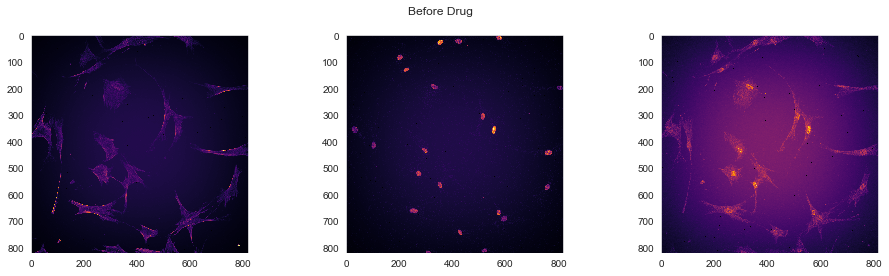

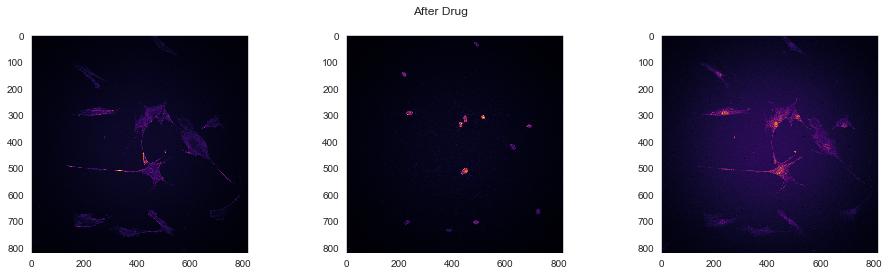

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].imshow(nodrug_slice["actin"])
ax[1].imshow(nodrug_slice['nucleus'])
ax[2].imshow(nodrug_slice["your_fav_protein"])
fig.suptitle('Before Drug')

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].imshow(drug_slice["actin"])
ax[1].imshow(drug_slice['nucleus'])
ax[2].imshow(drug_slice["your_fav_protein"])
fig.suptitle('After Drug')

3.1.5 Masking


In [12]:
#answer
def mask_im(im, threshold):
    mask = np.zeros(im.shape)
    mask[im >=threshold] = 1
    plt.imshow(mask, vmin = 0, vmax = 1)
    return(mask)

### Morphological Operations

3.2.1 Pre-set

In [13]:
from skimage.filters.rank import median as median_filter # Our Median Filter
from skimage.filters.rank import minimum as min_filter # Our background removal filter
from skimage.filters import threshold_otsu # Our Otsu

import skimage.morphology as sm
from skimage.morphology import disk

3.2.2. Pre-process and threshold



In [14]:
# Let's work only with one channel 

# Apply the median filt

# Apply the min filt

# Otsu threshold


3.2.3. Four Seperate Operation Results

In [15]:
# Let's do Erosion/Dilation together

# TRY WITH OPENING AND CLOSING


3.2.4. Optimized Operation Results (Closing-opening)

In [16]:
# Add morphological operations

### 3.3 Quantifications

3.3.1. Find cell body by getting rid of nuclei from the dialated actin mask 

In [29]:
from scipy.ndimage.filters import median_filter
from skimage import filters
import skimage.morphology as sm

channels_of_interest = ['actin', 'nucleus']
data = drug_slice
th_masked = {}
drug_masks = {}

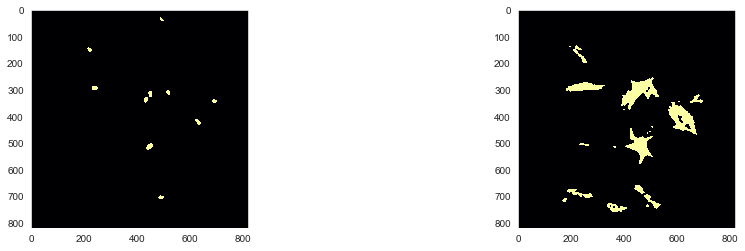

In [31]:
for channel in channels_of_interest:
    original = data[channel].copy() 
    filtered = median_filter(original, size=2)
    otsu_thresh = filters.threshold_otsu(filtered)
    th_masked[channel] = filtered > otsu_thresh

    morph1 = sm.binary_closing( th_masked[channel],sm.disk(3))
    morph2 = sm.binary_opening(morph1,sm.disk(3))

    drug_masks[channel] = morph2
    
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].imshow(drug_masks['nucleus'])
ax[1].imshow(drug_masks['actin'])

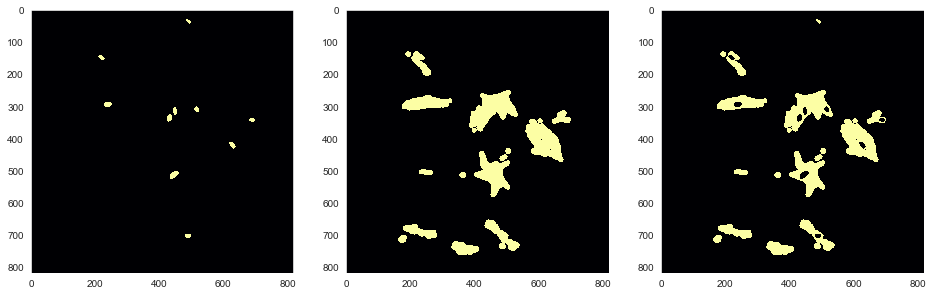

In [32]:
nucleus = drug_masks['nucleus'].copy()
actin = drug_masks['actin'].copy()

refined_actin_mask = sm.binary_dilation(actin, sm.disk(5))
refined_cell_body_mask= refined_actin_mask ^ nucleus

fig, ax = plt.subplots(1, 3, figsize=(16, 8))
ax[0].imshow(nucleus)
ax[1].imshow(refined_actin_mask)
ax[2].imshow(refined_cell_body_mask)

#### Calculate a mean nuclear and cytoplasmic intensities of *your_fav_protein*. For this, we'll apply our masks to the image of interest.

#### Challenge: process image #2

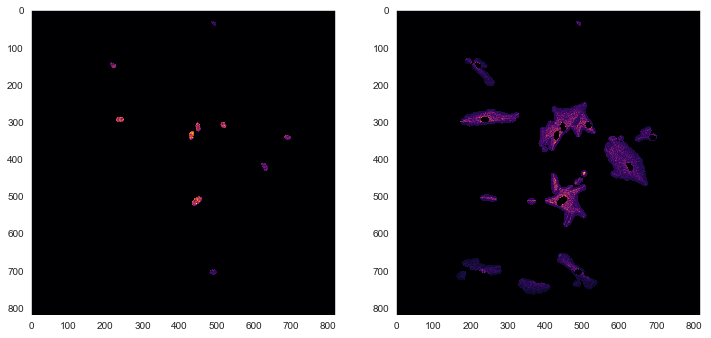

In [38]:
yfp = drug_slice['your_fav_protein']

nuclear_intensities = yfp.copy()
nuclear_intensities[~nucleus] = 0

cytoplasmic_intensities = yfp.copy()
cytoplasmic_intensities[~refined_cell_body_mask ] = 0

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(nuclear_intensities)
ax[1].imshow(cytoplasmic_intensities)

3.3.2. Final measure of nuclear and cytoplasmic averages

Average nuclear intensity after treatment is: 9095.387412040656
Average cytoplasmic intensity after treatment is: 3996.549021346397


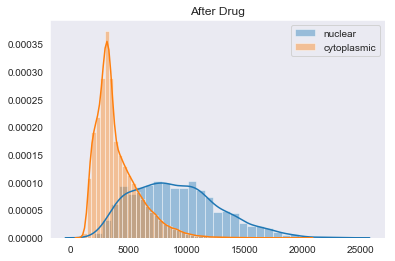

In [64]:
sns.distplot(nuclear_intensities[nuclear_intensities > 0].flatten(), kde=True, label='nuclear')
sns.distplot(cytoplasmic_intensities[cytoplasmic_intensities > 0].flatten(), kde=True, label='cytoplasmic')
plt.legend()
plt.title('After Drug')

print("Average nuclear intensity after treatment is: {}".format(np.mean(nuclear_intensities[nuclear_intensities > 0])))
print("Average cytoplasmic intensity after treatment is: {}".format(np.mean(cytoplasmic_intensities[cytoplasmic_intensities > 0])))

### 3.4 Quantifying Properties of Identified Regions or Cells


3.4.1. Load lable function and label cells with different colors

In [50]:
from skimage.measure import label

3.4.2. Load regionprops function and get the properties of the labeled cells


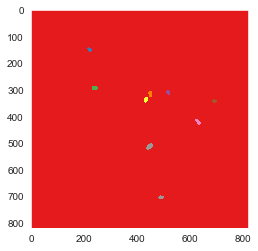

In [51]:
cell_labels = label(nucleus)
plt.imshow(cell_labels, cmap='Set1',vmin=0,vmax=cell_labels.max())

3.4.3. Load interactive function and show the chosen labeled cells

(<Figure size 864x432 with 2 Axes>, <matplotlib.image.AxesImage at 0x1577ca90>)

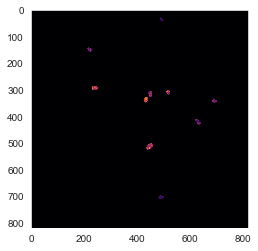

In [67]:
from skimage.measure import regionprops
from ipywidgets import interactive

props = regionprops(cell_labels, nuclear_intensities)

fig, plt.imshow(nuclear_intensities)

3.4.4. Show single cell mask properties: 6th cell's area

In [68]:
props[5].area

281

#### Challenge: what is the actual value of area in mm^2? Note: using the scale in meta data.

3.4.5. Show single cell mask properties: 6th cell's mean_intensity,centroid, weighted_centroid

In [69]:
props[5].mean_intensity

13444.996441281139

In [70]:
props[5].centroid

(335.9217081850534, 430.56939501779357)

In [71]:
props[5].weighted_centroid

(335.5611713362788, 430.5548566930401)

3.4.6. Measures of roundness


Ratio

In [73]:
bounding_box = props[5].bbox
aspect_ratio = 1. * (bounding_box[3] - bounding_box[1]) / (bounding_box[2] - bounding_box[0])
print(aspect_ratio)

0.6956521739130435


Solidity

In [74]:
props[5].solidity

0.972318339100346

Roundness

In [75]:
def circleness(properties):
    bounding_box = properties.bbox
    aspect_ratio = 1. * (bounding_box[3] - bounding_box[1]) / (bounding_box[2] - bounding_box[0])
    
    if aspect_ratio > 1:
        aspect_penalty = 1./aspect_ratio
    else:
        aspect_penalty = aspect_ratio
        
    return properties.solidity * aspect_penalty

circleness(props[5])

0.6763953663306755

### More properties you can get:
#### [link: full parameters in regionprops](http://scikit-image.org/docs/0.8.0/api/skimage.measure.html#skimage.measure.regionprops)